<a href="https://colab.research.google.com/github/suleman12344/Agentic_Assignemnts/blob/main/finalYear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip uninstall -y numpy pandas tensorflow

In [3]:
!pip uninstall -y --quiet numpy pandas tensorflow
!pip install --quiet numpy==1.24.3 pandas==2.2.2 tensorflow==2.17.0
!pip install  --quiet torch torchvision opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.


In [4]:
import os
DATASET_PATH = '/content/drive/MyDrive/cubicasa5k'

if os.path.exists(DATASET_PATH):
    print('Dataset exists')

else:
    print('Dataset does not exist')

Dataset exists


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FloorplanDataset(Dataset):
    def __init__(self, txt_file, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform

        # Read the text file and generate a list of all image paths
        with open(txt_file, 'r') as file:
            folders = [line.strip() for line in file.readlines()]


        self.image_files = []
        for folder in folders:
            folder_path = base_dir+folder#os.path.join(base_dir, folder)7

            self.image_files += [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [11]:
train_path = "/content/drive/MyDrive/cubicasa5k/train.txt"
train_dataset = FloorplanDataset(train_path, base_dir=DATASET_PATH, transform=transform)
test_path = "/content/drive/MyDrive/cubicasa5k/test.txt"
test_dataset = FloorplanDataset(test_path, base_dir=DATASET_PATH, transform=transform)
val_path = "/content/drive/MyDrive/cubicasa5k/val.txt"
val_dataset = FloorplanDataset(val_path, base_dir=DATASET_PATH, transform=transform)


/content/drive/MyDrive/cubicasa5k/high_quality_architectural/2564/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/6165/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/1021/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/5507/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/1269/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/5988/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/2123/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/6293/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/925/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/1171/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/9333/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/8815/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/1784/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/6335/
/content/drive/MyDrive/cubicasa5k/high_quality_architectural/49

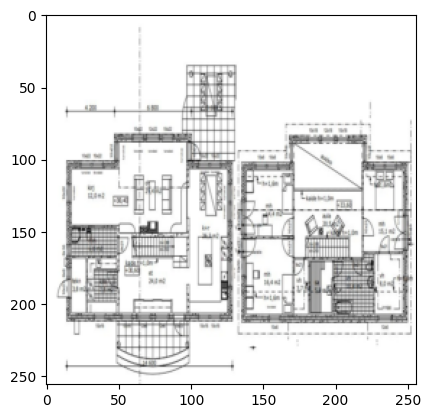

In [12]:
from matplotlib import pyplot as plt

sample_image = val_dataset[10]  # Get the first image
plt.imshow(sample_image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for visualization
plt.show()

#**Create Generator and Discriminator Models**

In [13]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.main = nn.Sequential(
            # Input is latent_dim
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # State size: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # State size: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # State size: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # State size: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

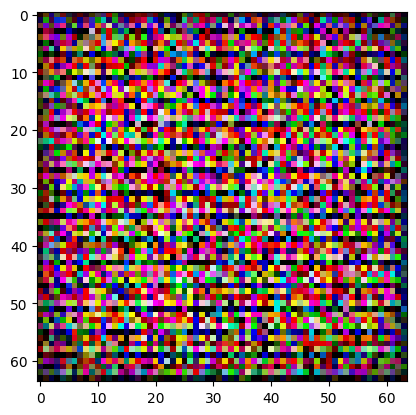

In [14]:
import torch
import matplotlib.pyplot as plt

# Initialize the Generator
latent_dim = 100
generator = Generator(latent_dim)

# Generate a random latent vector
noise = torch.randn(1, latent_dim, 1, 1)

# Pass the noise through the generator
fake_image = generator(noise)

# Plot the generated image
plt.imshow(fake_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
plt.show()


In [15]:
# Create a dummy image (real or fake)
real_image = torch.randn(1, 3, 64, 64)  # Random tensor simulating a real image

# Initialize the Discriminator
discriminator = Discriminator()

# Pass the image through the Discriminator
real_or_fake = discriminator(real_image)
print(f"Discriminator output (real or fake): {real_or_fake.item()}")


Discriminator output (real or fake): 0.5515612363815308


In [16]:
def train_model(dataloader, num_epochs=100):
    # Initialize models
    latent_dim = 100
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)

    # Loss function and optimizers
    criterion = nn.BCELoss()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for i, real_images in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size).to(device)
            label_fake = torch.zeros(batch_size).to(device)

            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)

            noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)

            g_loss.backward()
            g_optimizer.step()

            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}')

        # Save generated images periodically
        if (epoch + 1) % 10 == 0:
            save_generated_images(generator, epoch)

# Initialize and train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = FloorplanDataset(DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
train_model(dataloader)

TypeError: FloorplanDataset.__init__() missing 1 required positional argument: 'base_dir'